### The Effects of Polling in Multiwinner Elections
This notebook is complementary to the paper *The Effects of Polls in Multiwinner Elections* (Van den Oever, et al., 2023). It shows the example usage of our simulation tool `PiMWE` (**P**olls **i**n **M**ulti**W**inner **E**lections). The aim is twofold: to allow for the reproduction of the results claimed in the paper and to aid the reader by suggesting possible adaptations to tailor it for his own research purposes.

#### Imports 

In [1]:
import numpy as np

from PiMWE.parties import Party
from PiMWE.voters import Saint, Spineless, Follower, Opportunist, NonConformist, Strategist
from PiMWE.election import DHondt

from PiMWE.sampling import sample_parties, sample_voters
from PiMWE.plotting import plot_spectrum, plot_seats_over_time, plot_flow_graph

`parties.py`: containst the `Party` class. Each instance is defined by a `name`, `idx` and `position`  on the politcal spectrum.\
\
`voters.py`: contains the `Voter` class and its childclasses `Saint`, `Spineless`, `Follower`, `Opportunist`, `NonConformist`, `Strategist`. They are defined by an `id`, `position` on the political spectrum, `preference` order over parties and possibly additional arguments `k` and/or `g` (see paper). If needed, the user is free to add new votertypes to this class.\
\
`election.py` contains the `Election` class that runs the election. It is defined by the `parties`, `voters`, `num_seats` for the parliament to elect and `num_polls` voting rounds. Right now, the only apportionment rule implemented is the `DHondt` method (see paper), however, the user can add new apportionment rules if he likes.\
\
`sampling.py` consists of sampling functions for both the parties `sample_parties` and voters `sample_voters`. They define our spatial voting model and are implemented such that the preference orders are single-peaked for all voters (unless in the `sample_voters` we set `shuffle=True`, in which case the preferences are somewhat shuffled).\
Different sampling distributions can be chosen, however we strongly recommend the `'multimodal'` setting  with `dim=2` (which simulates a quite realistic Mixture of Gaussians distribution for voters) and set `representation=True` in `sample_parties`, such that every cluster of voters is represented at least by one party. Naturally, the parties and voters can also be defined manually.\
\
`plotting.py` contains the plotting functions responsible for the figures in the paper.

#### Case Study I: The 2023 Dutch Elections
To examplify the basic use of `PiMWE`, we study the 2023 Dutch Elections for the House of Representatives (Dutch: Tweede Kamer). The Dutch House consists of 150 seats. During the election, 26 parties were on the ballot, however, only 15 were elected. For sake of simplicity we consider only the parties that obtained at least one seat in the actual elections. \
To place parties we use the political spectrum from Kieskompas.nl (see 'data' folder). To distribute voters over the parties, we sample clusters around these points, with sizes that are equal to the relative sizes of the parties in the combined polls of I&O Research and IPSOS/EenVandaag on 21-10-2023 (see 'data' folder). This is exactly one month prior to the actual elections. The `DEMOGRAPHIC`, i.e., the number of each type voter, is based on data of I&O Research on the certainty level of voters on 23-10-2023. They consider three levels: *certain*, which we identify with `Saint`, *uncertain*: `Opportunist`, `NonConformist`, `Strategist`, and *undecided* (Dutch: zwevend): `Followers` and `Spineless`. Differences between parties are not considered and subdivisions between types are  arbitrary. We take a total of 10000 voters.

##### Election

In [2]:
#INITIALIZE ELECTION

#Estimated demographic of voters based on data of I&O Research on 23/10/2023
DEMOGRAPHIC = {Saint:[[] for i in range(1900)], 
               Spineless:[[]for i in range(300)],
               Follower:[[2] for i in range(500)] + [[3] for i in range(750)] + [[4] for i in range(750)],
               Opportunist:[[2] for i in range(1000)] + [[3] for i in range(1000)] +[[4] for i in range(1000)],
               NonConformist:[[3] for i in range(800)],
               Strategist:[[4,3] for i in range(1000)] + [[2,3] for i in range(1000)]
               }
#Parties in the 2023 Dutch election
party_names = ['PvdD', 'SP', 'DENK', 'GL/PvdA', 'CU', 'Volt', 'NSC', 'D66', 
               'PVV', 'BBB', 'CDA', 'SGP', 'VVD', 'FvD', 'JA21']

party_positions = [ [-60, 52], [-48, 14], [-43, 14], [-34, 42], [-20, 13], [-9, 54], [-5, -5], [-3, 37],
                   [5, -46], [6, -27], [14, -15], [17,-28], [32, -20], [40, -58], [49, -56]]

num_parties = len(party_names)

parties = [Party(party_names[i],idx=i, position=party_positions[i]) for i in range(num_parties) ]

#Estimated cluster size for each party, differences between parties are not considered
reach = [15 for i in range(num_parties)]

#Estimated relative size between parties based on data of I&O Research and IPSOS/EenVandaag on 21/10/2023
weights = np.array([4.4, 3.5, 2.5, 15.0, 2.7, 2.8, 17.1, 4.8,
           11.3, 7.4, 2.9, 2.3, 17.3, 2.8, 0.6])
weights /= sum(weights)

voter_clusters = {'modes':[{'mean': party_positions[i], 'std':reach[i], 'weight':weights[i]} for i in range(num_parties)]}

#Additional hyperparameters
NUM_ELECTIONS = 10
NUM_SEATS = 150
NUM_POLLS = 5
DIM = 2

In [3]:
#RUN ELECTION (estimated runtime: ~ 20s)

np.random.seed(26)
outcomes = [] #stores the poll and election results
elections = [] #stores the election instances after termination

for election in range(NUM_ELECTIONS):
    voters = sample_voters(DEMOGRAPHIC, parties, distribution='multimodal', dim=DIM, params=voter_clusters, shuffle=False)
    DutchElection = DHondt(voters, parties, num_seats=NUM_SEATS, num_polls=NUM_POLLS)
    outcome = DutchElection.run()
    outcomes.append(outcome)
    elections.append(DutchElection)

##### Visualisation
Below we visualise the election outcomes. We plot the party and voter distributions with `plot_spectrum`, the seat distribution as function of time with `plot_seats_over_time` and a flow graph with `plot_flow_graph` that shows the how the voters switched between initial preference and final vote.

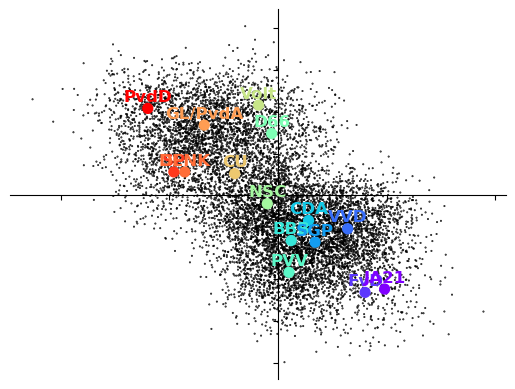

In [6]:
#Plotting political spectrum
plot_spectrum(voters, parties, vcmap=None, pcmap=None)

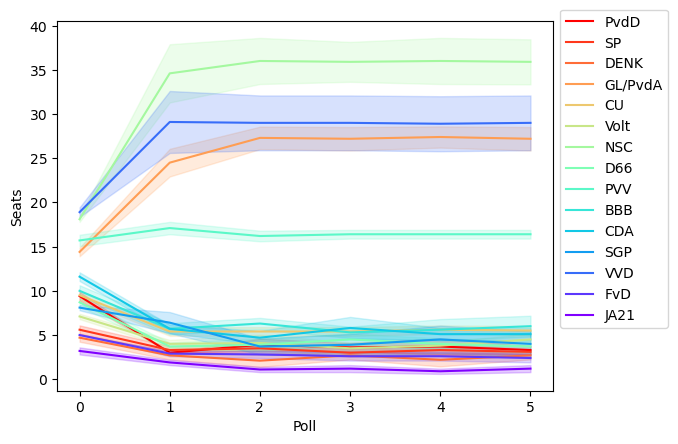

In [7]:
#plotting seats per party as function of the polls
plot_seats_over_time(outcomes)

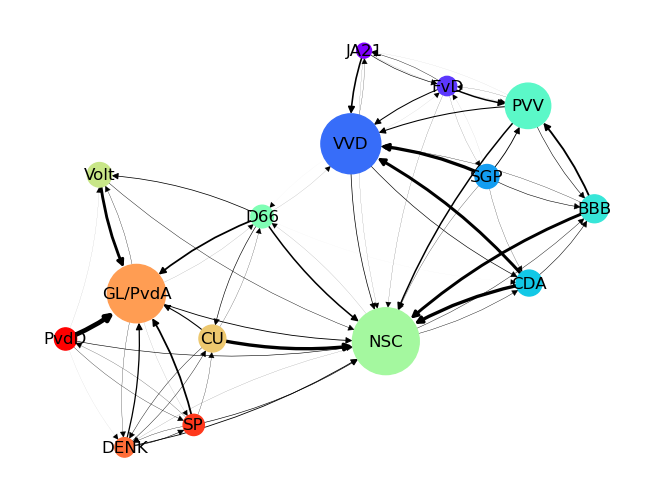

In [8]:
#plotting the voting switches between parties
plot_flow_graph(elections)

##### Observations

#### Case Study II: Polarisation in Election
For the second case study we look at an election that consists of two polarising parties, on opposite site of the spectrum, according to the polarasition metric defined in our paper. We compute this with `Party.compute_poldeg`.